<a href="https://colab.research.google.com/github/norhum/reinforcement-learning-from-scratch/blob/main/lecture4_REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transitioning to Policy Gradient Methods

So far, our approaches (Q-learning, SARSA, DQN) have focused on learning a **value function** (like Q-values), which tells us how good it is to be in a state or take an action. The policy was then derived *indirectly* from these values (e.g., by picking the action with the highest Q-value).

There's a different family of algorithms called **Policy Gradient methods** that learn the **policy directly**.

Instead of learning values first, the idea is to represent the agent's policy π (its strategy) directly as a function, usually a neural network. This network takes the current state *s* as input and outputs information about which action *a* to take.
*   For **discrete** action spaces (like Left/Right), the network might output probabilities for each action: π(a|s) = P[A=a | S=s].
*   For **continuous** action spaces (like setting a motor torque), it might output parameters (e.g., mean, standard deviation) of a probability distribution over actions.

The network *is* the policy. The goal is to adjust the network's parameters directly to maximize the expected cumulative reward.

### Introducing Gymnasium and CartPole

Now, to try out Policy Gradients, we need an environment. While we could build another custom one, developing and debugging environments takes significant effort.

Luckily, the **Gymnasium** library (a maintained fork and successor to OpenAI Gym) provides a wide range of pre-built environments designed for benchmarking RL algorithms. This lets us focus on the agent's learning logic.

We'll use a classic Gymnasium environment called **CartPole-v1**.

https://gymnasium.farama.org/environments/classic_control/cart_pole/

*   **Goal:** Balance a vertical pole on top of a cart that moves along a track.
*   **Observation Space (State):** What the agent sees. It's a vector of 4 continuous values:
    1.  Cart Position
    2.  Cart Velocity
    3.  Pole Angle (0 is upright)
    4.  Pole Angular Velocity (how fast it's tipping)
*   **Action Space:** What the agent can do. It's discrete with 2 actions:
    *   0: Push cart Left
    *   1: Push cart Right
*   **Reward:** The agent receives a +1 reward for every time step the pole remains upright within certain angle limits and the cart stays within track boundaries.
*   **Episode Termination:** An episode ends if:
    *   The pole angle exceeds a threshold (pole falls).
    *   The cart position exceeds boundaries (cart goes off track).
    *   A time limit (500 steps for v1) is reached (truncated).
*   **Objective:** Maximize the total reward by keeping the pole balanced for as long as possible (up to 500 steps).

### The REINFORCE Algorithm

Alright, let's implement our first Policy Gradient agent using the **REINFORCE** algorithm (also known as Monte Carlo Policy Gradient).

REINFORCE works by:
1.  Running a full episode using the current policy network to collect a trajectory of states, actions, and rewards.
2.  Calculating the **discounted return** (total future discounted reward) *G<sub>t</sub>* for each time step *t* in the episode.
3.  Adjusting the policy network's parameters to increase the probability of actions that led to high returns and decrease the probability of actions that led to low returns.

It learns directly from the total outcome of an episode.

### Training Flow Overview (`train_agent_cartpole`)

Before defining the agent class, let's understand the structure of the main training function, `train_agent_cartpole`, described in the script:


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

def train_agent_cartpole(episodes=1000, hidden_size=64, lr=1e-3, gamma=0.99, print_every=50, save_path="best_reinforce_agent.pth"):
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Instantiate agent and move to device
    agent = PolicyGradientAgentDiscrete(state_size, action_size, hidden_size, lr).to(device)

    episode_rewards = []
    # Use deque for efficient fixed-size window for recent rewards
    from collections import deque
    recent_rewards = deque(maxlen=print_every) # Store only last 'print_every' rewards

    best_avg_reward = -float('inf') # Initialize best average reward

    for episode in range(episodes):
        state_np, info = env.reset() # Get initial state (numpy array)
        states_memory, actions_memory, rewards_memory = [], [], [] # Buffers for the episode
        total_reward = 0
        terminated = False
        truncated = False

        # Run episode up to max steps defined by environment spec
        for t in range(env.spec.max_episode_steps):
            action_tensor = agent.get_action(state_np) # Get action tensor (contains index)
            action_int = action_tensor.item() # Extract integer action for env.step

            # Execute action in environment
            next_state_np, reward, terminated, truncated, info = env.step(action_int)

            # Store experience (state as tensor, action as tensor, reward as number)
            state_tensor = torch.tensor(state_np, dtype=torch.float32).to(device)
            states_memory.append(state_tensor)
            actions_memory.append(action_tensor)
            rewards_memory.append(reward)

            state_np = next_state_np # Move to next state
            total_reward += reward

            # Check if episode ended
            if terminated or truncated:
                break

        # Train agent at the end of the episode
        loss = agent.train(states_memory, actions_memory, rewards_memory, gamma)

        # Record performance
        episode_rewards.append(total_reward)
        recent_rewards.append(total_reward)

        # Calculate average reward over the recent window
        current_avg_reward = np.mean(recent_rewards) # Mean of deque handles variable size correctly

        # Save best model
        if current_avg_reward > best_avg_reward:
            best_avg_reward = current_avg_reward
            # Save the model's state dictionary
            torch.save(agent.state_dict(), save_path)

        # Print progress
        if (episode + 1) % print_every == 0:
            print(f"Episode {episode + 1}/{episodes} | Avg Reward (Last {len(recent_rewards)}): {current_avg_reward:.2f} | Loss: {loss:.4f}") # Loss from last training step

    print(f"Training finished. Best average reward: {best_avg_reward:.2f} saved to {save_path}")
    env.close()
    return agent, episode_rewards


1.  **Initialization:**
    *   Creates the `CartPole-v1` environment using `gym.make`.
    *   Gets state and action space sizes from the environment.
    *   Instantiates the policy gradient agent (`PolicyGradientAgentDiscrete`).
    *   Sets up lists/variables for tracking rewards (`episode_rewards`, `recent_rewards`) and saving the best model (`best_avg_reward`, `save_path`).
2.  **Episode Loop:** Runs for the specified number of `episodes`.
    *   **Reset:** Resets the environment (`env.reset()`) to get the initial state. Initializes lists (`states_memory`, `actions_memory`, `rewards_memory`) to store the trajectory for the current episode.
    *   **Step Loop:** Runs for a maximum number of steps (`env.spec.max_episode_steps`).
        *   Agent selects an `action` based on the current `state` using its policy network (`agent.get_action`).
        *   Environment performs the action (`env.step(action)`), returning `next_state`, `reward`, `terminated`, `truncated`.
        *   Stores the `state`, `action`, and `reward` in the memory lists.
        *   Updates the current `state` and `total_reward`.
        *   Breaks the loop if the episode ends (`terminated` or `truncated`).
    *   **Agent Training:** After the episode finishes, calls `agent.train()` with the collected states, actions, and rewards for that episode. This is the **Monte Carlo** aspect – updating only after the full episode outcome is known.
    *   **Performance Tracking:** Updates `episode_rewards` and the `recent_rewards` window. Calculates `current_avg_reward`.
    *   **Model Saving:** If `current_avg_reward` is the best seen so far, saves the agent's network weights (`agent.state_dict()`) to `save_path`.
    *   **Logging:** Prints progress periodically.
3.  **Cleanup:** Closes the environment (`env.close()`). Returns the trained agent and the history of episode rewards.

### Implementing the REINFORCE Agent (`PolicyGradientAgentDiscrete`)

Now let's define the agent class, which includes the policy network.

In [2]:
class PolicyGradientAgentDiscrete(nn.Module): # Inherit from nn.Module
    def __init__(self, state_size, action_size, hidden_size, lr):
        super().__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size

        # Define network layers
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size) # Outputs logits for actions

        # Define optimizer
        self.optimizer = optim.AdamW(self.parameters(), lr=lr)

    def forward(self, state):
        # Define the forward pass through the network
        x = F.relu(self.fc1(state))
        logits = self.fc2(x) # Raw scores for each action
        return logits

    def get_action(self, state):
        # Convert state to tensor and move to device
        state = torch.tensor(state, dtype=torch.float32).to(device)

        with torch.no_grad(): # No need to track gradients for action selection
            logits = self.forward(state)
            # Convert logits to probabilities using softmax
            probs = torch.softmax(logits, dim=-1) # Softmax over the action dimension
            # Sample an action based on the probabilities
            # multinomial expects probabilities, returns indices
            action = torch.multinomial(probs, num_samples=1).squeeze() # Remove extra dimension

        # Return the action tensor (contains the index)
        return action

    def train(self, states, actions, rewards, gamma):
        # Calculate discounted returns (Gt) for the episode
        returns = []
        discounted_reward = 0
        # Iterate backwards through rewards to calculate discounted return
        for r in reversed(rewards):
            discounted_reward = r + gamma * discounted_reward
            returns.insert(0, discounted_reward) # Insert at the beginning

        # Convert lists to tensors
        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        states_tensor = torch.stack(states).to(device) # Stack list of state tensors
        actions_tensor = torch.stack(actions).to(device) # Stack list of action tensors

        # Normalize returns (improves stability, acts as a baseline)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8) # Add epsilon for numerical stability

        # --- Calculate Loss ---
        # Get logits from the network for all states in the episode
        logits = self.forward(states_tensor)
        # Convert logits to probabilities
        probs = torch.softmax(logits, dim=-1)

        # Get the probabilities of the actions that were actually taken
        # Need actions as LongTensor indices for gather, ensure correct shape
        actions_tensor = actions_tensor.long().unsqueeze(-1) # Shape [T, 1] where T is episode length
        action_probs = probs.gather(dim=-1, index=actions_tensor).squeeze(-1) # Shape [T]

        # Calculate log probabilities (add epsilon for stability)
        log_probs = torch.log(action_probs + 1e-8)

        # Calculate policy gradient loss: - mean(log_probs * Returns)
        # We want to maximize log_prob for actions with high positive returns
        # and minimize log_prob for actions with high negative returns (after normalization)
        # Taking the negative mean turns maximization into minimization for the optimizer
        loss = -(log_probs * returns).mean()

        # --- Update Network ---
        self.optimizer.zero_grad() # Reset gradients
        loss.backward()          # Calculate gradients
        self.optimizer.step()     # Update weights

        # Return the loss value for monitoring
        return loss.item()

#### Understanding `PolicyGradientAgentDiscrete`:

*   **Inheritance:** Inherits from `torch.nn.Module`, the base class for all PyTorch neural network modules.
*   **`__init__`**: Stores sizes and learning rate (`lr`). Defines the network layers (`fc1`, `fc2`) which constitute a simple MLP. Creates the `AdamW` optimizer, passing `self.parameters()` so the optimizer knows which tensors (weights and biases) to update.
*   **`forward`**: Defines how input `state` flows through the layers (`fc1` -> `ReLU` -> `fc2`) to produce output `logits` (raw scores for each action).
*   **`get_action`**:
    *   Takes the current `state` (assumed to be a NumPy array or similar).
    *   Converts the state to a PyTorch tensor and moves it to the correct `device`.
    *   Passes the state through the network (`self.forward`) to get `logits`.
    *   Applies `softmax` to the `logits` to get a probability distribution (`probs`) over actions.
    *   Uses `torch.multinomial` to **sample** an action index based on these probabilities. This is crucial for exploration in policy gradients. It doesn't just pick the highest probability (argmax).
    *   Returns the chosen `action` as a tensor containing the action index.
*   **`train`**: This implements the core REINFORCE update, performed *after* an entire episode is collected.
    *   Takes lists of `states`, `actions`, and `rewards` from the episode.
    *   **Calculate Returns:** Iterates *backwards* through the episode's `rewards` to compute the discounted return *G<sub>t</sub>* for each time step *t*. `discounted_reward = r + gamma * discounted_reward`.
    *   **Normalize Returns:** Converts the calculated `returns` to a tensor and normalizes them (subtract mean, divide by standard deviation). This simple form of baseline subtraction significantly reduces variance and stabilizes training. Actions leading to returns *above the episode's average* are encouraged, while those below average are discouraged.
    *   **Calculate Loss:**
        *   Gets action probabilities (`probs`) from the network for all `states` in the episode.
        *   Uses `gather` to select the probabilities (`action_probs`) corresponding to the `actions` actually taken during the episode.
        *   Calculates the log-probabilities (`log_probs`) of the taken actions.
        *   The loss is the **negative mean** of `log_probs * normalized_returns`. Minimizing this loss effectively performs gradient *ascent* on the policy's performance objective (makes good actions more likely, bad actions less likely).
    *   **Update Network:** Performs the standard PyTorch optimizer steps (`zero_grad`, `backward`, `step`) to update the policy network's weights based on the calculated loss.

### Training the REINFORCE Agent on CartPole

Now, let's define the plotting function, then run the training.

Using device: cuda
Training Policy Gradient (REINFORCE) Agent on CartPole-v1:
Episode 50/1500 | Avg Reward (Last 50): 24.16 | Loss: 0.0211
Episode 100/1500 | Avg Reward (Last 50): 18.34 | Loss: 0.0421
Episode 150/1500 | Avg Reward (Last 50): 18.38 | Loss: -0.0218
Episode 200/1500 | Avg Reward (Last 50): 21.24 | Loss: 0.0059
Episode 250/1500 | Avg Reward (Last 50): 39.48 | Loss: -0.0032
Episode 300/1500 | Avg Reward (Last 50): 54.80 | Loss: -0.0148
Episode 350/1500 | Avg Reward (Last 50): 111.62 | Loss: -0.0341
Episode 400/1500 | Avg Reward (Last 50): 202.78 | Loss: -0.0803
Episode 450/1500 | Avg Reward (Last 50): 242.14 | Loss: -0.0176
Episode 500/1500 | Avg Reward (Last 50): 307.66 | Loss: -0.0354
Episode 550/1500 | Avg Reward (Last 50): 342.84 | Loss: -0.0199
Episode 600/1500 | Avg Reward (Last 50): 396.26 | Loss: -0.0058
Episode 650/1500 | Avg Reward (Last 50): 429.84 | Loss: -0.0044
Episode 700/1500 | Avg Reward (Last 50): 284.58 | Loss: -0.0022
Episode 750/1500 | Avg Reward (Last 

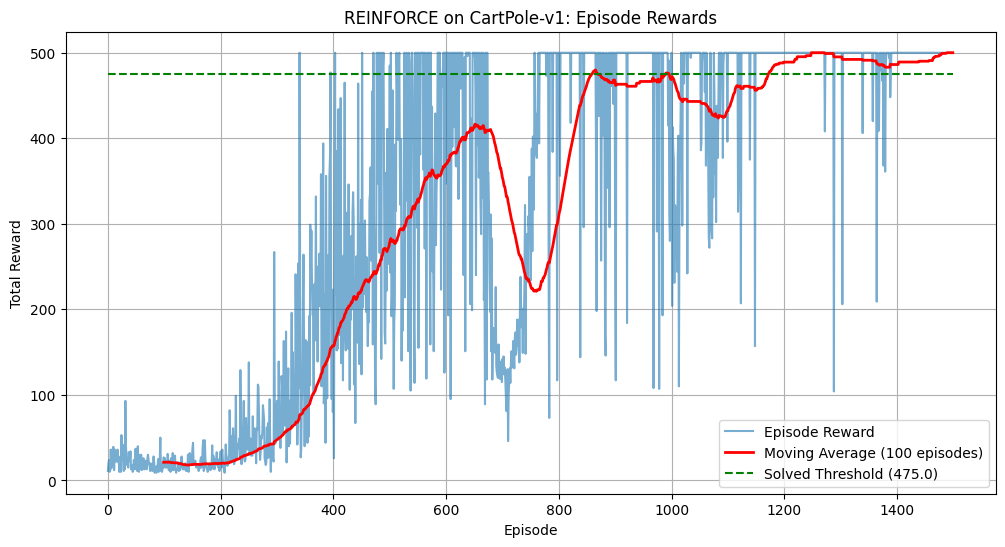

In [3]:
def plot_rewards(rewards, window=100):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Episode Reward', alpha=0.6)
    if len(rewards) >= window:
        # Use numpy convolve for moving average
        moving_avg = np.convolve(np.array(rewards), np.ones(window)/window, mode='valid')
        plt.plot(np.arange(window-1, len(rewards)), moving_avg, label=f'Moving Average ({window} episodes)', color='red', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('REINFORCE on CartPole-v1: Episode Rewards')
    # Get reward threshold from Gymnasium spec
    reward_threshold = gym.spec("CartPole-v1").reward_threshold
    # Check if threshold is meaningful relative to plot limits before drawing
    if reward_threshold is not None and plt.ylim()[1] > reward_threshold * 0.8 :
        plt.hlines(reward_threshold, 0, len(rewards), colors='g', linestyles='dashed', label=f'Solved Threshold ({reward_threshold})')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Execution Logic ---
# Define device (should be defined globally or re-defined here)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set seed for reproducibility
torch.manual_seed(42)

print("Training Policy Gradient (REINFORCE) Agent on CartPole-v1:")
save_file_path = "best_reinforce_cartpole.pth"

# Call the training function
trained_agent_reinforce, rewards_history_reinforce = train_agent_cartpole(
    episodes=1500,
    hidden_size=64,
    lr=2e-3,
    gamma=0.99,
    print_every=50,
    save_path=save_file_path
)

# Plot the results
plot_rewards(rewards_history_reinforce)

### Analyzing REINFORCE Performance

Alright! So, we ran our code using REINFORCE for 1500 episodes. Let's check out the plot showing how it did!

*   **Raw Rewards (Blue Line):** Notice how noisy and jumpy the reward is for individual episodes. This is characteristic of REINFORCE.
*   **Moving Average (Red Line):** This smooths out the noise and shows the learning trend. It starts low, gradually increases as the policy improves, and eventually crosses the green dashed line representing the 'solved' threshold for CartPole-v1 (average reward >= 475 over 100 episodes).
*   **Success:** The agent clearly learned to balance the pole successfully for extended periods.

**Why the High Variance (Noisy Blue Line)?**
REINFORCE updates the policy based on the *total discounted return* of an *entire* episode. This return is highly susceptible to chance events during the episode.
*   The policy itself is **stochastic** (it samples actions using `torch.multinomial`).
*   A single unlucky action taken early on purely by chance (even with a generally good policy) can lead to the pole falling much earlier, resulting in a low total reward for that specific episode.
*   Conversely, a string of lucky actions might lead to an unusually high reward.

This reliance on the full episode's outcome makes the learning signal (the calculated return) have **high variance**. This doesn't prevent learning, but it can make it slower and less stable compared to methods that learn more incrementally.

Bottom line: REINFORCE worked! It learned to balance the pole despite the noisy learning process.

### Rendering the Trained Agent

We saved the weights of the best performing agent during training. Let's load those weights and watch the agent in action.

In [6]:
from matplotlib import animation
from IPython.display import HTML

render_env_temp = gym.make('CartPole-v1')
state_size_render = render_env_temp.observation_space.shape[0]
action_size_render = render_env_temp.action_space.n
render_env_temp.close()

best_agent = PolicyGradientAgentDiscrete(state_size_render, action_size_render, hidden_size=64, lr=0).to(device)

best_agent.load_state_dict(torch.load(save_file_path, map_location=device))

# Create environment with rgb_array render mode
render_env = gym.make('CartPole-v1', render_mode='rgb_array')

num_render_episodes = 3
max_steps = 500

def run_episode_and_create_animation(episode_num):
    # Reset environment
    state_np, info = render_env.reset(seed=100 + episode_num)

    frames = []
    total_reward = 0
    terminated = False
    truncated = False
    step_count = 0

    while not (terminated or truncated) and step_count < max_steps:
        # Capture every frame
        frame = render_env.render()
        frames.append(frame)

        # Get action from your agent
        action_tensor = best_agent.get_action(state_np)
        action = action_tensor.item()

        # Take step
        state_np, reward, terminated, truncated, info = render_env.step(action)

        total_reward += reward
        step_count += 1

    print(f"Episode {episode_num + 1} | Total Reward: {total_reward}")

    # Create animation from frames
    plt.figure(figsize=(frames[0].shape[1]/100, frames[0].shape[0]/100), dpi=100)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        return [patch]

    anim = animation.FuncAnimation(
        plt.gcf(), animate, frames=len(frames), interval=20, blit=True)

    plt.close()  # Prevent display of the static figure

    return anim, total_reward

# Run episodes and display animations
for episode in range(num_render_episodes):
    anim, reward = run_episode_and_create_animation(episode)
    display(HTML(f"<h2>Episode {episode+1} - Total Reward: {reward}</h2>"))
    display(HTML(anim.to_jshtml()))

render_env.close()

Episode 1 | Total Reward: 500.0


Episode 2 | Total Reward: 500.0


Episode 3 | Total Reward: 500.0


<!-- Code Cell Output: A window should pop up showing the CartPole environment being controlled by the trained agent for a few episodes. -->

#### Observing Agent Behavior

You might notice interesting variations in the agent's behavior during rendering, even if it achieves the maximum reward:
*   Sometimes the cart might move rapidly back and forth (jittery).
*   Other times, it might stay relatively still with only small adjustments.

This highlights that the agent learns purely based on the reward signal. The CartPole reward is simple: +1 for every step the pole is balanced. It doesn't penalize jerky movements or reward smooth control.

Therefore, the agent finds *any* strategy that maximizes survival time, regardless of aesthetics or efficiency. If rapid adjustments keep the pole up for 500 steps, that's considered optimal by the agent according to the given reward function. To encourage smoother control, the reward function itself would need to be modified (e.g., adding penalties for large actions or high velocities).

---

### REINFORCE Recap and Next Steps

Okay, so REINFORCE got the job done on CartPole! But, we noticed that even though the average trend went up, the performance episode-to-episode was really shaky. That shakiness points directly to the main headache with basic REINFORCE: it has **high variance**.

**Advantages of Policy Gradients (like REINFORCE):**
*   **Direct Policy Learning:** Optimizes the policy directly.
*   **Handles Continuous Actions:** Can naturally output parameters for continuous action distributions (unlike standard DQN which struggles with infinite actions).

**Disadvantages of Basic REINFORCE:**
*   **High Variance:** Learning signal based on full-episode return is noisy, making learning sample-inefficient and potentially unstable.
*   **On-Policy:** Typically learns from data collected using the *current* policy and then discards it, potentially requiring many episodes.

The high variance is a major drawback. We need a way to get a better, less noisy estimate of how good an action was *without* relying solely on the final outcome of the entire episode.

This leads us to **Actor-Critic methods**. These methods combine the direct policy learning of Policy Gradients with value function estimation (like we saw in DQN) to get the best of both worlds. We'll focus on a popular variant called **A2C (Advantage Actor-Critic)** next.

**Actor-Critic Idea:**
*   **Actor:** The policy network (like in REINFORCE) that outputs action probabilities or parameters.
*   **Critic:** A separate value network that learns the **state-value function V(s)** – the expected return starting from state *s* and following the current policy.
*   **Advantage:** Instead of updating the Actor using the noisy full return *G<sub>t</sub>*, update it using the **Advantage** *A(s, a) = Q(s, a) - V(s)*. This measures how much *better* taking action *a* was compared to the *average* expected value of being in state *s* (estimated by the Critic). This Advantage signal has much lower variance than the raw return.

A2C uses the Critic to provide a baseline, allowing the Actor to learn more stably and efficiently using the Advantage signal.

Now, let's apply this Actor-Critic idea to a continuous control problem: the Pendulum environment.